## PROYECTO MACHINE LEARNING
#### NFL ODDS PREDICTION

In [ ]:
from utils.libreries import *

In [2]:
file_path = "data/raw/spreadspoke_scores.csv"

#Hacemos la llamada a nuestro DF
scores = pd.read_csv(file_path)
scores.head(5)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN


In [3]:
scores.describe().T

,count,mean,std,min,25%,50%,75%,max
schedule_season,13516.0,1996.082939,16.144258,1966.0,1983.0,1997.0,2010.0,2022.0
score_home,13516.0,22.461897,10.526423,0.0,15.0,22.0,29.0,72.0
score_away,13516.0,19.784848,10.165222,0.0,13.0,20.0,27.0,62.0
spread_favorite,11037.0,-5.385204,3.439617,-26.5,-7.0,-4.5,-3.0,0.0
weather_temperature,12309.0,58.833211,15.538656,-6.0,48.0,62.0,72.0,97.0
weather_wind_mph,12293.0,7.689010,5.694124,0.0,3.0,8.0,11.0,40.0
weather_humidity,8468.0,67.212801,15.796414,4.0,57.0,69.0,79.0,100.0


In [4]:
scores.isnull().sum()

schedule_date              0
schedule_season            0
schedule_week              0
schedule_playoff           0
team_home                  0
score_home                 0
score_away                 0
team_away                  0
team_favorite_id        2479
spread_favorite         2479
over_under_line         2489
stadium                    0
stadium_neutral            0
weather_temperature     1207
weather_wind_mph        1223
weather_humidity        5048
weather_detail         10597
dtype: int64

In [5]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13516 entries, 0 to 13515
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        13516 non-null  object 
 1   schedule_season      13516 non-null  int64  
 2   schedule_week        13516 non-null  object 
 3   schedule_playoff     13516 non-null  bool   
 4   team_home            13516 non-null  object 
 5   score_home           13516 non-null  int64  
 6   score_away           13516 non-null  int64  
 7   team_away            13516 non-null  object 
 8   team_favorite_id     11037 non-null  object 
 9   spread_favorite      11037 non-null  float64
 10  over_under_line      11027 non-null  object 
 11  stadium              13516 non-null  object 
 12  stadium_neutral      13516 non-null  bool   
 13  weather_temperature  12309 non-null  float64
 14  weather_wind_mph     12293 non-null  float64
 15  weather_humidity     8468 non-null  

### DATA PROCESSING

Después de cargar nuestros datos en crudo procedemos a trabajar sobre ellos.

In [6]:
#Nos quedamos solo con la temporada regular. Procedemos a eliminar los playoffs
scores = scores[scores['schedule_playoff'] == 0]
scores = scores.loc[scores['schedule_season'] >= 1980]

In [7]:
#Establecemos como punto de partida la temporada 1980.
# scores = scores.loc[scores['schedule_season'] >= 1980]

In [8]:
#Cambiamos el formato de las columnas para que sean numéricas
scores = scores.astype({'schedule_playoff': int,
                        'schedule_week': int,
                        'over_under_line': float
                        })

In [31]:
from datetime import datetime

def transform_date(schedule_date):
    """
    Transforma la fecha en formato "mm/dd/yyyy" a "mm-dd-yyyy".
    """
    date1 = datetime.strptime(schedule_date, "%m/%d/%Y")
    return date1.strftime("%m-%d-%Y")

# Transformar la columna 'schedule_date' del DataFrame 'scores'
scores['schedule_date'] = scores['schedule_date'].apply(transform_date)


In [32]:
#Eliminamos los NANs de las columnas debido su antiguedad y que pueden ser irrelevantes
scores.isnull().sum()

schedule_date             0
schedule_season           0
schedule_week             0
schedule_playoff          0
team_home                 0
score_home                0
score_away                0
team_away                 0
team_favorite_id          0
spread_favorite           0
over_under_line           0
stadium                   0
stadium_neutral           0
weather_temperature     692
weather_wind_mph        691
weather_humidity       4188
weather_detail         7690
dtype: int64

In [33]:
# Eliminamos las columnas que no nos interesan debido a alto numero de NANs "weather_detail", "weather_humidity"
# Eliminamos la columna "schedule_playoff" que no nos interesa 

scores = scores.drop(columns=["schedule_playoff","weather_detail", "weather_humidity", "stadium_neutral"])

In [34]:
#Tratamos los Nans de nuestras columnas. Para la columna "weather_temperature" utizamos media al ser simitrica su distrubucion.
# Para la columna "weather_humidity" la media debido a que tiende a ser una distrubucion logaritmica.
scores = scores.fillna({'weather_temperature': scores['weather_temperature'].median(),
                        'weather_wind_mph': (scores['weather_wind_mph'].median())})


In [35]:
scores = scores.reset_index(drop=True)

In [36]:
scores

,schedule_date,schedule_season,schedule_week,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,weather_temperature,weather_wind_mph
0,09-07-1980,1980,1,Buffalo Bills,17,7,Miami Dolphins,MIA,-3.0,35.0,Ralph Wilson Stadium,64.0,8.0
1,09-07-1980,1980,1,Cincinnati Bengals,12,17,Tampa Bay Buccaneers,TB,-1.0,34.0,Cinergy Field,72.0,9.0
2,09-07-1980,1980,1,Green Bay Packers,12,6,Chicago Bears,CHI,-6.0,35.0,Lambeau Field,65.0,5.0
3,09-07-1980,1980,1,Kansas City Chiefs,14,27,Oakland Raiders,KC,-3.0,42.0,Arrowhead Stadium,82.0,10.0
4,09-07-1980,1980,1,Los Angeles Rams,20,41,Detroit Lions,LAR,-9.0,38.0,Anaheim Stadium,66.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10312,01-08-2023,2022,18,Philadelphia Eagles,22,16,New York Giants,PHI,-17.0,43.0,Lincoln Financial Field,64.0,7.0
10313,01-08-2023,2022,18,Pittsburgh Steelers,28,14,Cleveland Browns,PIT,-2.5,40.0,Acrisure Stadium,64.0,7.0
10314,01-08-2023,2022,18,San Francisco 49ers,38,13,Arizona Cardinals,SF,-14.5,40.0,Levi's Stadium,64.0,7.0
10315,01-08-2023,2022,18,Seattle Seahawks,19,16,Los Angeles Rams,SEA,-4.5,43.0,Lumen Field,64.0,7.0


### FEATURES

In [37]:
# Calcula la diferencia de puntajes entre el equipo local y visitante
scores['score_diff'] = scores['score_home'] - scores['score_away']


In [38]:
#Creamos nuestro target llamado "winner"
def calcular_ganador(row):
    if row['score_home'] > row['score_away']:
        return 1
    elif row['score_home'] < row['score_away']:
        return 0
    else:
        return "tie"

# Creamos la nueva columna "winner" que será nuestro target
scores['winner'] = scores.apply(calcular_ganador, axis=1)


In [39]:
#Buscamos un resultado de victoria y vemos que desde 1980 en temporada regular solo han habido 26 empates procedemos a eliminarlo.
scores["winner"].value_counts()

1      5896
0      4395
tie      26
Name: winner, dtype: int64

In [40]:
scores = scores[scores['winner'] != "tie"]

In [41]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10291 entries, 0 to 10316
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        10291 non-null  object 
 1   schedule_season      10291 non-null  int64  
 2   schedule_week        10291 non-null  int64  
 3   team_home            10291 non-null  object 
 4   score_home           10291 non-null  int64  
 5   score_away           10291 non-null  int64  
 6   team_away            10291 non-null  object 
 7   team_favorite_id     10291 non-null  object 
 8   spread_favorite      10291 non-null  float64
 9   over_under_line      10291 non-null  float64
 10  stadium              10291 non-null  object 
 11  weather_temperature  10291 non-null  float64
 12  weather_wind_mph     10291 non-null  float64
 13  score_diff           10291 non-null  int64  
 14  winner               10291 non-null  object 
dtypes: float64(4), int64(5), object(6)
m

In [42]:
scores = scores.astype({'winner': int,
                        "team_home":"category",
                        "team_away":"category",
                        "team_favorite_id":"category",
                        "stadium":"category",
                        })

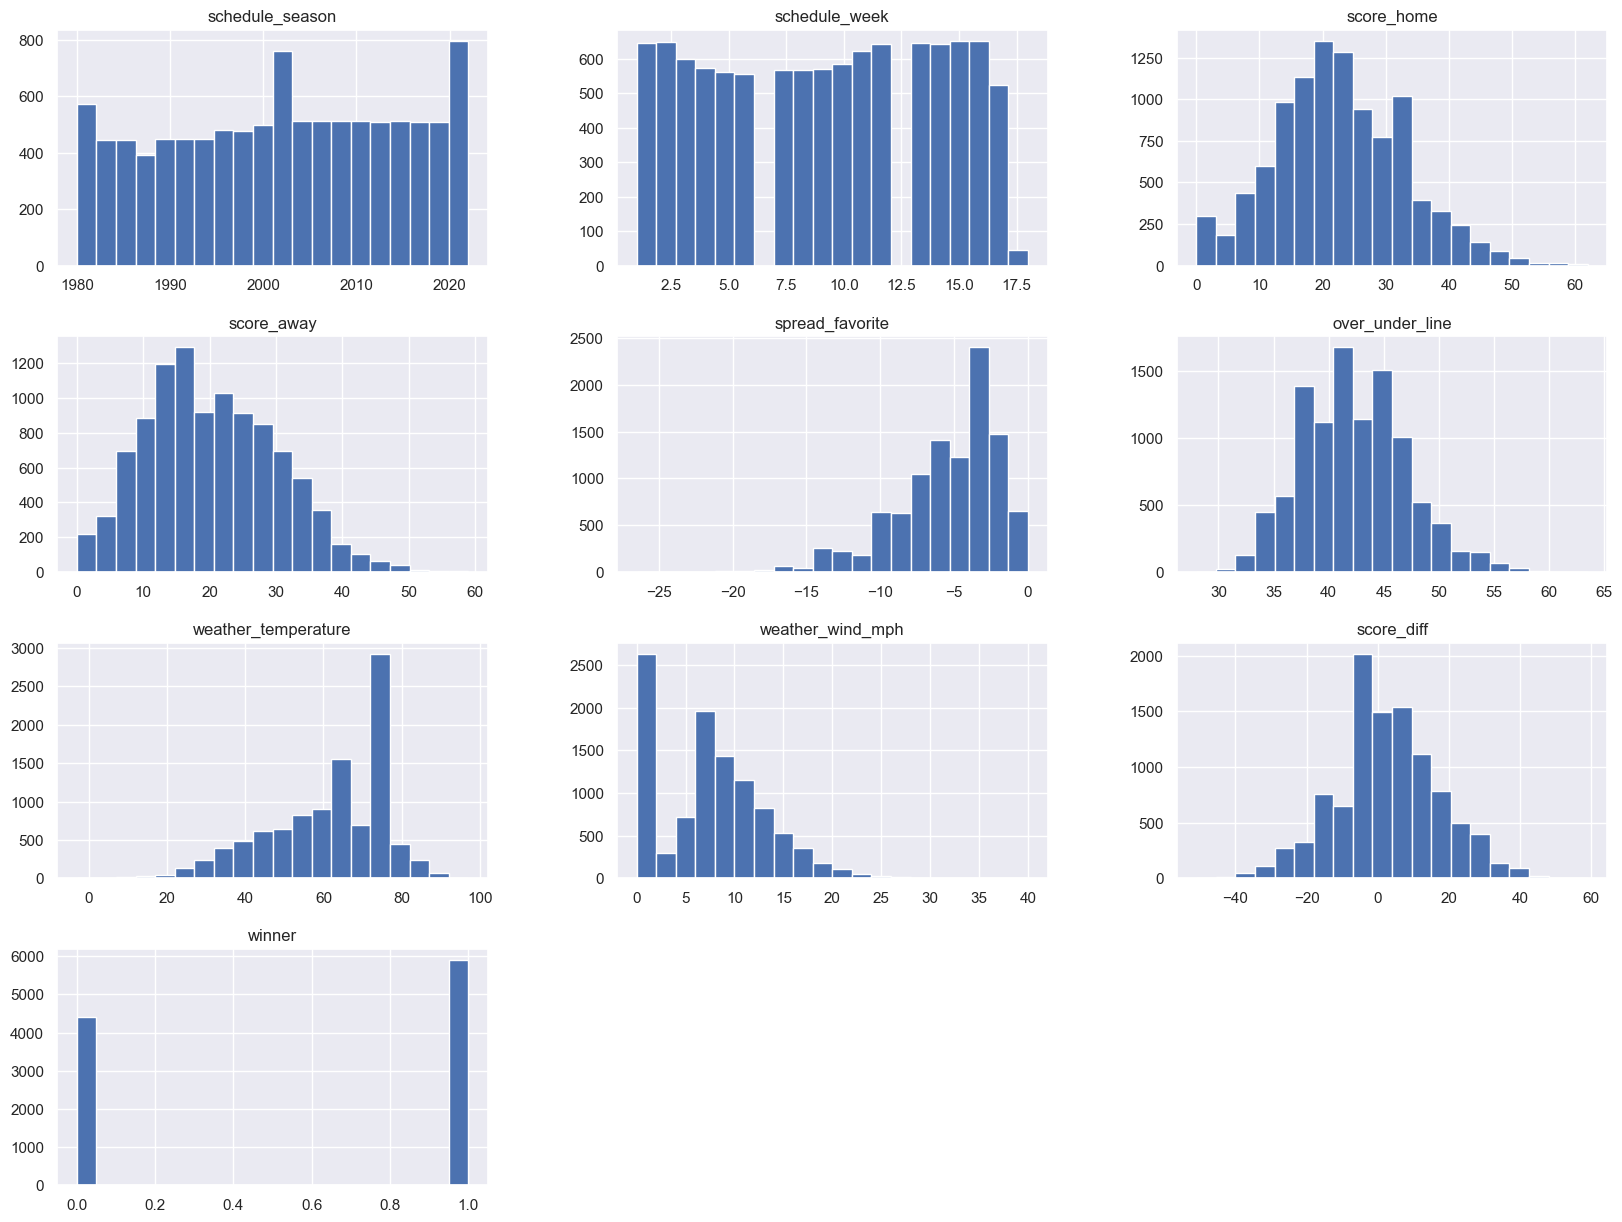

In [48]:
scores.hist(bins=20, figsize=(20,15));

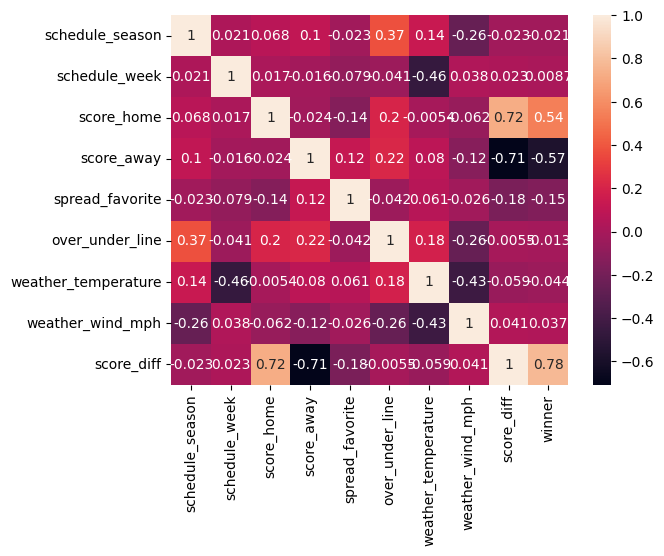

In [22]:
sns.heatmap(scores.corr().drop(["winner"]), annot=True);

In [ ]:
#Guardamos nuevo dataframe con los datos limpios en CSV


In [ ]:
#Cargamos los datos limpios

In [50]:
#Observamos un target balancedo
scores['winner'].value_counts()/len(scores['winner'])*100

1    57.29278
0    42.70722
Name: winner, dtype: float64

## 5. Preparacion del modelo

In [51]:
X = scores.drop(['winner'], axis=1)
y = scores['winner'].copy()
X.shape

(10291, 14)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
scaler_X_train = scaler.fit_transform(X_train)

In [ ]:
scaler_X_test = scaler.transform(X_test)

## 6. Modelos de clasificación y evaluación:

#### 6.1 Logistic Regression

In [ ]:
log_model = LogisticRegression()

In [ ]:
log_model.fit(scaler_X_train,y_train)

In [ ]:
pred_lg = log_model.predict(scaler_X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_lg)*100)
print("Accuracy:",accuracy_score(y_test, pred_lg)*100)
print("Precision:",precision_score(y_test, pred_lg)*100)

#### 6.2 Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaler_X_train,y_train)

In [ ]:
pred_dt = dt.predict(scaler_X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_dt)*100)
print("Accuracy:",accuracy_score(y_test, pred_dt)*100)
print("Precision:",precision_score(y_test, pred_dt)*100)

#### 6.3 Random Forest

In [ ]:
r_forest = RandomForestClassifier()

In [ ]:
r_forest.fit(X_train, y_train)

In [ ]:
r_forest.fit(X_train, y_train)
pred_r_forest = r_forest.predict(X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_dt)*100)
print("Accuracy:",accuracy_score(y_test, pred_dt)*100)
print("Precision:",precision_score(y_test, pred_dt)*100)

#### 6.4 KNN

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(scaler_X_train,y_train)

In [ ]:
pred_knn = knn.predict(scaler_X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_knn)*100)
print("Accuracy:",accuracy_score(y_test, pred_knn)*100)
print("Precision:",precision_score(y_test, pred_knn)*100)

#### 6.5 SVM

In [ ]:
svm = SVC()

In [ ]:
svm.fit(scaler_X_train,y_train)

In [ ]:
pred_svm = svm.predict(scaler_X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_svm)*100)
print("Accuracy:",accuracy_score(y_test, pred_svm)*100)
print("Precision:",precision_score(y_test, pred_svm)*100)

#### 6.6 GaussianNB

In [ ]:
gnb = GaussianNB()

In [ ]:
gnb.fit(X_train, y_train)

In [ ]:
pred_gnb = gnb.predict(X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_svm)*100)
print("Accuracy:",accuracy_score(y_test, pred_svm)*100)
print("Precision:",precision_score(y_test, pred_svm)*100)

#### 6.7 XGBoost

In [ ]:
xgb = xgb.XGBClassifier()

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
pred_xgb = xgb.predict(X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_svm)*100)
print("Accuracy:",accuracy_score(y_test, pred_svm)*100)
print("Precision:",precision_score(y_test, pred_svm)*100)

#### 6.8 CatBoost

In [ ]:
cat = AdaBoostClassifier()

In [ ]:
cat.fit(X_train, y_train)

In [ ]:
pred_cat = cat.predict(X_test)

In [ ]:
print("ROC:",roc_auc_score(y_test, pred_svm)*100)
print("Accuracy:",accuracy_score(y_test, pred_svm)*100)
print("Precision:",precision_score(y_test, pred_svm)*100)